In [1]:
import numpy as np
import pandas as pd
import copy

In [110]:
df = pd.read_csv('RELIANCE5.csv')

df['date'] = pd.to_datetime(df['date'])
df= df.set_index('date')


In [111]:
mindf = (df.resample('10min', base=5)
               .agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'mean'}))

ma = mindf['close'].rolling(window=20).mean()
mindf['ma']=ma
mindf=mindf.dropna()

In [112]:
import pandas_datareader as web
from pandas import DataFrame

In [113]:
start = mindf.first_valid_index().strftime('%Y-%m-%d')
end = mindf.last_valid_index().strftime('%Y-%m-%d')
dailydf = web.DataReader("RELIANCE.NS", 'yahoo', start, end)

#dailydf = (df.resample('1 D')
#               .agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'mean'}))


dailydf=dailydf.dropna()
dma = dailydf['Adj Close'].rolling(window=20).mean()
dailydf['ma']=dma
dailydf=dailydf.dropna()
dailydf=DataFrame(dailydf)



In [114]:
dailydf = dailydf.drop(columns=['Close','Volume'])
dailydf.columns=['high','low','open','close','ma']
dailydf = dailydf.rename(index={'Date': 'date'})
dailydf.head()

,high,low,open,close,ma
Date,,,,,
2015-11-10,479.750000,458.149994,478.500000,441.818207,450.203297
2015-11-13,469.274994,457.250000,457.524994,446.749908,451.147745
2015-11-16,471.000000,462.375000,463.000000,447.348419,451.898273
2015-11-17,469.450012,463.100006,469.024994,444.212250,452.474039
2015-11-18,465.649994,454.975006,463.799988,436.671021,452.407005


In [115]:
pivots= (dailydf['high'].shift(1) + dailydf['low'].shift(1) + dailydf['close'].shift(1))/3

r1 = 2*pivots.shift(1) - dailydf['low'].shift(1)

In [116]:
dailydf['pivot'] = pivots
dailydf['r1'] = r1
dailydf = dailydf.dropna()   
dailydf.head()

,high,low,open,close,ma,pivot,r1
Date,,,,,,,
2015-11-16,471.000000,462.375000,463.000000,447.348419,451.898273,457.758301,462.562134
2015-11-17,469.450012,463.100006,469.024994,444.212250,452.474039,460.241140,453.141602
2015-11-18,465.649994,454.975006,463.799988,436.671021,452.407005,458.920756,457.382273
2015-11-19,469.350006,458.625000,459.450012,447.563873,451.718721,452.432007,462.866506
2015-11-20,476.399994,462.774994,467.000000,453.357422,451.482907,458.512960,446.239014


In [117]:
dailydf['ret']=0
dailydf1 = copy.deepcopy(dailydf)

In [118]:
capital = 100000
dailydf1['cap']=100000
dailydf1.head()
returns = dailydf1['cap']
dailydf1

,high,low,open,close,ma,pivot,r1,ret,cap
Date,,,,,,,,,
2015-11-16,471.000000,462.375000,463.000000,447.348419,451.898273,457.758301,462.562134,0,100000
2015-11-17,469.450012,463.100006,469.024994,444.212250,452.474039,460.241140,453.141602,0,100000
2015-11-18,465.649994,454.975006,463.799988,436.671021,452.407005,458.920756,457.382273,0,100000
2015-11-19,469.350006,458.625000,459.450012,447.563873,451.718721,452.432007,462.866506,0,100000
2015-11-20,476.399994,462.774994,467.000000,453.357422,451.482907,458.512960,446.239014,0,100000
...,...,...,...,...,...,...,...,...,...
2020-10-30,2065.100098,2021.800049,2033.500000,2054.500000,2158.672498,2019.966675,2060.033285,0,100000
2020-11-02,2027.000000,1859.150024,2027.000000,1877.449951,2141.934998,2047.133382,2018.133301,0,100000
2020-11-03,1909.000000,1835.099976,1890.000000,1850.400024,2123.937494,1921.199992,2235.116740,0,100000


In [119]:
def getTrailingReturns(df,r1,capital):
    pos = 0
    entry = 0
    sl = 0
    risk = capital*0.01
    size = 0
    profit = 0
    firsttgt=0
    for index, row in df.iterrows():
        if(pos==0):
            if(row['close']>r1 and entry==0):
                entry=row['high']
                sl = row['low']
                size = round(risk/(entry-sl))
                firsttgt = entry + (2*(entry-sl))
            elif(row['high']>entry and entry!=0):
                pos = 1
        else:
            if(row['low']<sl):
                return size*(sl-entry)
            elif(row.high>firsttgt):
                return size*(firsttgt-entry)
            elif(row['low']<sl):
                return size*(sl-entry)
            if(index.time() == pd.to_datetime('15:05').time()):
                return size*(row['close'] - entry)
    return profit  

In [7]:

import pandas as pd
import datetime
datetime.datetime.now().hour < 14

True

In [120]:
def getReturns(df,r1,capital):
    pos = 0
    entry = 0
    sl = 0
    risk = capital*0.01
    size = 0
    for index, row in df.iterrows():
        if(row['close']>r1 and pos==0 and entry==0 and row.close>row.ma): 
            entry=row['high']
            sl = row['low']
            if(entry-sl == 0):
                print(index)
            size = round(risk/(entry-sl))
        if(row['high']>entry and pos==0 and entry!=0):
            pos = 1
        if(row['low']<sl and pos==1):
            return size*(sl-entry)
        if(index.time() == pd.to_datetime('15:05').time() and pos==1):
            return size*(row['close'] - entry)
    return 0  
    

In [123]:
dailydf['signal'] = np.where(dailydf.close>dailydf.ma,1,0)
dailydf['signal'] = dailydf['signal'].shift(1)
dailydf = dailydf.dropna()

mindf = mindf.query("low != high")

In [124]:
capital = 100000
for index, row in dailydf.iterrows():
    dailyr = 0
    if(row.open!=row.close and row.low!=row.high):
        dailyr = getReturns(mindf.loc[index.strftime('%Y-%m-%d')], row.r1, capital)
        capital = capital + dailyr
        dailydf1.at[index.strftime('%Y-%m-%d'), 'ret']= dailyr
        returns.at[index.strftime('%Y-%m-%d')] = capital



In [125]:
capital

340305.24999999616

In [126]:
%matplotlib inline

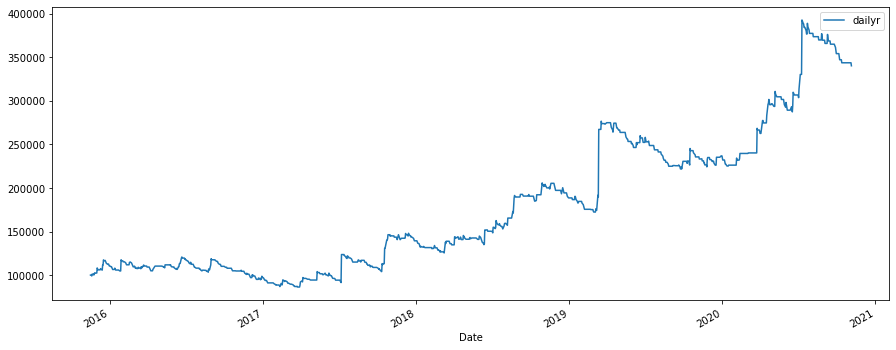

In [127]:
dailydf1['dailyr']=returns
dailydf1.plot(y='dailyr',figsize=(15, 6))

In [128]:
returns


Date
2015-11-16    100000.00
2015-11-17    100000.00
2015-11-18    100000.00
2015-11-19     99000.40
2015-11-20    101099.20
                ...    
2020-10-30    343745.05
2020-11-02    343745.05
2020-11-03    343745.05
2020-11-04    343745.05
2020-11-05    340305.25
Name: cap, Length: 1227, dtype: float64

In [129]:
CAGR = (311476/100000)**(1/5)-1

In [130]:
dailydf1.head(10)

,high,low,open,close,ma,pivot,r1,ret,cap,dailyr
Date,,,,,,,,,,
2015-11-16,471.000000,462.375000,463.000000,447.348419,451.898273,457.758301,462.562134,0.0,100000.0,100000.0
2015-11-17,469.450012,463.100006,469.024994,444.212250,452.474039,460.241140,453.141602,0.0,100000.0,100000.0
2015-11-18,465.649994,454.975006,463.799988,436.671021,452.407005,458.920756,457.382273,0.0,100000.0,100000.0
2015-11-19,469.350006,458.625000,459.450012,447.563873,451.718721,452.432007,462.866506,-999.6,99000.4,99000.4
2015-11-20,476.399994,462.774994,467.000000,453.357422,451.482907,458.512960,446.239014,2098.8,101099.2,101099.2
2015-11-23,478.950012,473.100006,475.000000,456.661224,451.452985,464.177470,454.250926,0.0,101099.2,101099.2
2015-11-24,485.799988,475.524994,476.500000,463.340515,451.741463,469.570414,455.254934,-1010.4,100088.8,100088.8
2015-11-26,495.975006,484.125000,485.500000,473.371552,452.837932,474.888499,463.615835,2502.5,102591.3,102591.3
2015-11-27,496.250000,487.049988,494.500000,468.774963,453.783572,484.490519,465.651998,-248.8,102342.5,102342.5


In [131]:
noOfTrades = np.count_nonzero(dailydf1.ret)
noOfPositiveTrades = np.count_nonzero(dailydf1.ret>0)
noOfNegativeTrades = np.count_nonzero(dailydf1.ret<0)
maxGain = np.amax(dailydf1.ret)
maxLoss = np.amin(dailydf1.ret)



In [132]:
noOfNegativeTrades

402

In [133]:
noOfPositiveTrades

173

In [134]:
maxGain

77493.5

In [37]:
dailydf1.to_csv('AXISRESULTS.csv')